In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import sys
from mediapipe.python.solutions import drawing_utils, hands
from mediapipe.python.solutions.drawing_utils import DrawingSpec
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from numpy import ndarray
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

In [3]:
def get_image(image_path: str) -> ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def write_image(image: ndarray, output_path: str) -> None:
    make_dir(output_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, image)

In [4]:
dataset = 'MNIST Dataset'

data = []

for label in os.listdir(dataset):
    label_path = os.path.join(dataset, label)
    count = len(os.listdir(label_path))
    
    data.append((count, label))
    
    
print(data)

[(5996, 'A'), (5996, 'B'), (5996, 'C'), (5996, 'D'), (5996, 'E'), (5996, 'F'), (5996, 'G'), (5996, 'H'), (5996, 'I'), (5996, 'J'), (5996, 'K'), (5996, 'L'), (5996, 'M'), (5996, 'N'), (5996, 'Nothing'), (5996, 'O'), (5996, 'P'), (5996, 'Q'), (5966, 'R'), (5996, 'S'), (5886, 'Space'), (5648, 'T'), (4542, 'U'), (5996, 'V'), (5996, 'W'), (5996, 'X'), (5720, 'Y'), (5996, 'Z')]


In [5]:
def annotate_image(image: ndarray, landmarks: list) -> ndarray:
    annotated_image = image.copy()
    for landmark in landmarks:
        drawing_utils.draw_landmarks(
            annotated_image,
            landmark,
            hands.HAND_CONNECTIONS,
            DrawingSpec(color=(255, 0, 0), thickness=10, circle_radius=10),
            DrawingSpec(color=(0, 255, 0), thickness=5, circle_radius=2),
        )
    return annotated_image

def make_dir(path: str) -> None:
    path_list = path.split("\\")
    current_path = ""

    if path_list[-1].find('.') != -1:
        path_list = path_list[:-1]

    for path in path_list:
        current_path = os.path.join(current_path, path)
        if not os.path.exists(current_path):
            os.mkdir(current_path)

In [6]:
class MediaPipeConverter:
    def __init__(self):
        self.hands = hands.Hands(
            static_image_mode=False,
            max_num_hands=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.landmark_data = []

    def get_landmarks(self, image: ndarray) -> list:
        results = self.hands.process(image)

        if not results.multi_hand_landmarks:
            return []

        return results.multi_hand_landmarks

    def process_directory(self, label: str, input_dir: str, output_dir: str) -> None:
        for filename in os.listdir(input_dir):
            image_path = os.path.join(input_dir, filename)
            image = get_image(image_path)

            landmarks = self.get_landmarks(image)
            self.convert_to_dict(filename, label, landmarks)

            annotated_image = annotate_image(image, landmarks)

            output_path = os.path.join(output_dir, filename)
            write_image(annotated_image, output_path)

            print("Finished Processing", flush=True)

    def convert_to_dict(self, name: str, label: str, landmarks: str) -> None:
        if landmarks is None:
            landmarks = []

        if len(landmarks) > 0:
            first_hand = np.array([landmark for landmark in landmarks[0].landmark]).flatten()
        else:
            first_hand = np.zeros(21)

        if len(landmarks) > 1:
            second_hand = np.array([landmark for landmark in landmarks[1].landmark]).flatten()
        else:
            second_hand = np.zeros(21)

        for i in range(2):
            hand_landmarks = []
            if i == 0:
                hand_landmarks.extend(first_hand)
                hand_landmarks.extend(second_hand)
            else:
                hand_landmarks.extend(second_hand)
                hand_landmarks.extend(first_hand)

            hand_data = {
                "Image_No": name,
                "Label": label
            }

            rel_coords = np.zeros(3)

            for j, landmark in enumerate(hand_landmarks):
                if landmark is None:
                    for dim in ['x', 'y', 'z']:
                        hand_data[f"Landmark_{j + 1}_{dim}"] = 0
                    continue

                if j % 21 == 0:
                    for k, dim in enumerate(['x', 'y', 'z']):
                        rel_coords[k] = getattr(hand_landmarks[j], dim, 0)

                for k, dim in enumerate(['x', 'y', 'z']):
                    hand_data[f"Landmark_{j + 1}_{dim}"] = getattr(landmark, dim, 0) - rel_coords[k]

            self.landmark_data.append(hand_data)

    def dump_to_csv(self, output_path: str) -> None:
        df = pd.DataFrame(self.landmark_data)

        make_dir(output_path)
        if os.path.exists(output_path):
            old_df = pd.read_csv(output_path)
            df = pd.concat([old_df, df], ignore_index=True)

        df.to_csv(output_path, index=False)

In [7]:
output_path = 'MNIST Dataset Processed/output.csv'

df = pd.read_csv(output_path)

In [8]:
df.head()

,Image_No,Label,Landmark_1_x,Landmark_1_y,Landmark_1_z,Landmark_2_x,Landmark_2_y,Landmark_2_z,Landmark_3_x,Landmark_3_y,...,Landmark_39_z,Landmark_40_x,Landmark_40_y,Landmark_40_z,Landmark_41_x,Landmark_41_y,Landmark_41_z,Landmark_42_x,Landmark_42_y,Landmark_42_z
0,10.jpg,A,0.0,0.0,0.0,-0.170927,-0.048236,-0.037922,-0.304534,-0.180382,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,10.jpg,A,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.019590,0.020981,-0.457122,-0.062364,0.008663,-0.350085,-0.030556,0.014394,-0.290293,0.009869
2,100.jpg,A,0.0,0.0,0.0,-0.102444,-0.005990,-0.040114,-0.191728,-0.108021,...,-0.030801,-0.056995,-0.289178,-0.038694,-0.076732,-0.202964,-0.014929,-0.076062,-0.166585,0.008049
3,100.jpg,A,0.0,0.0,0.0,-0.059198,-0.110328,-0.009876,-0.116228,-0.232210,...,-0.029405,0.046481,-0.269913,-0.059896,0.043397,-0.199472,-0.037555,0.041827,-0.173103,-0.010595
4,1000.jpg,A,0.0,0.0,0.0,-0.105603,-0.059444,-0.039185,-0.181308,-0.149336,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
df.describe()

,Landmark_1_x,Landmark_1_y,Landmark_1_z,Landmark_2_x,Landmark_2_y,Landmark_2_z,Landmark_3_x,Landmark_3_y,Landmark_3_z,Landmark_4_x,...,Landmark_39_z,Landmark_40_x,Landmark_40_y,Landmark_40_z,Landmark_41_x,Landmark_41_y,Landmark_41_z,Landmark_42_x,Landmark_42_y,Landmark_42_z
count,331340.0,331340.0,331340.0,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,...,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000,331340.000000
mean,0.0,0.0,0.0,-0.028400,-0.034176,-0.021542,-0.037130,-0.079635,-0.035461,-0.020260,...,-0.037387,0.091043,-0.123620,-0.056470,0.082202,-0.115948,-0.053822,0.075790,-0.112215,-0.047142
std,0.0,0.0,0.0,0.062444,0.050677,0.041916,0.114457,0.108720,0.064334,0.149973,...,0.059612,0.135624,0.171744,0.078780,0.144393,0.177124,0.076298,0.153790,0.186590,0.072485
min,0.0,0.0,0.0,-0.198321,-0.219931,-0.309747,-0.354442,-0.392413,-0.539041,-0.458432,...,-0.647711,-0.253984,-0.645533,-0.813714,-0.332851,-0.699026,-0.852993,-0.419986,-0.797679,-0.910875
25%,0.0,0.0,0.0,-0.083742,-0.075154,-0.042743,-0.120672,-0.182790,-0.065543,-0.056121,...,-0.063359,0.000000,-0.286922,-0.098984,0.000000,-0.246699,-0.093363,0.000000,-0.222143,-0.081222
50%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.139243,0.000000,0.000000,0.109413,0.000000,0.000000,0.092082,0.000000,0.000000
max,0.0,0.0,0.0,0.249167,0.131519,0.224089,0.409415,0.269543,0.303032,0.553662,...,0.227338,0.627159,0.399112,0.240855,0.755456,0.541721,0.265469,0.863501,0.672854,0.288745


In [10]:
df.dtypes

Image_No          object
Label             object
Landmark_1_x     float64
Landmark_1_y     float64
Landmark_1_z     float64
                  ...   
Landmark_41_y    float64
Landmark_41_z    float64
Landmark_42_x    float64
Landmark_42_y    float64
Landmark_42_z    float64
Length: 128, dtype: object

In [11]:
df.shape

(331340, 128)

In [12]:
df.isnull().sum()

Image_No         0
Label            0
Landmark_1_x     0
Landmark_1_y     0
Landmark_1_z     0
                ..
Landmark_41_y    0
Landmark_41_z    0
Landmark_42_x    0
Landmark_42_y    0
Landmark_42_z    0
Length: 128, dtype: int64

In [13]:
encoder = LabelEncoder()

label = df['Label']
label = encoder.fit_transform(label)

In [14]:
x_df = df
x_df['Label'] = label
x_df = x_df.drop(columns=['Image_No', 'Landmark_1_x', 'Landmark_1_y', 'Landmark_1_z'])

In [15]:
x_df.head()

,Label,Landmark_2_x,Landmark_2_y,Landmark_2_z,Landmark_3_x,Landmark_3_y,Landmark_3_z,Landmark_4_x,Landmark_4_y,Landmark_4_z,...,Landmark_39_z,Landmark_40_x,Landmark_40_y,Landmark_40_z,Landmark_41_x,Landmark_41_y,Landmark_41_z,Landmark_42_x,Landmark_42_y,Landmark_42_z
0,0,-0.170927,-0.048236,-0.037922,-0.304534,-0.180382,-0.045544,-0.352715,-0.329054,-0.061141,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.019590,0.020981,-0.457122,-0.062364,0.008663,-0.350085,-0.030556,0.014394,-0.290293,0.009869
2,0,-0.102444,-0.005990,-0.040114,-0.191728,-0.108021,-0.049358,-0.215117,-0.216885,-0.057813,...,-0.030801,-0.056995,-0.289178,-0.038694,-0.076732,-0.202964,-0.014929,-0.076062,-0.166585,0.008049
3,0,-0.059198,-0.110328,-0.009876,-0.116228,-0.232210,-0.006714,-0.165892,-0.322574,-0.013379,...,-0.029405,0.046481,-0.269913,-0.059896,0.043397,-0.199472,-0.037555,0.041827,-0.173103,-0.010595
4,0,-0.105603,-0.059444,-0.039185,-0.181308,-0.149336,-0.058449,-0.193830,-0.256361,-0.081112,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
x_df.replace(0, 10e-5, inplace=True)

In [17]:
x_df.head()

,Label,Landmark_2_x,Landmark_2_y,Landmark_2_z,Landmark_3_x,Landmark_3_y,Landmark_3_z,Landmark_4_x,Landmark_4_y,Landmark_4_z,...,Landmark_39_z,Landmark_40_x,Landmark_40_y,Landmark_40_z,Landmark_41_x,Landmark_41_y,Landmark_41_z,Landmark_42_x,Landmark_42_y,Landmark_42_z
0,0.0001,-0.170927,-0.048236,-0.037922,-0.304534,-0.180382,-0.045544,-0.352715,-0.329054,-0.061141,...,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100
1,0.0001,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,...,-0.019590,0.020981,-0.457122,-0.062364,0.008663,-0.350085,-0.030556,0.014394,-0.290293,0.009869
2,0.0001,-0.102444,-0.005990,-0.040114,-0.191728,-0.108021,-0.049358,-0.215117,-0.216885,-0.057813,...,-0.030801,-0.056995,-0.289178,-0.038694,-0.076732,-0.202964,-0.014929,-0.076062,-0.166585,0.008049
3,0.0001,-0.059198,-0.110328,-0.009876,-0.116228,-0.232210,-0.006714,-0.165892,-0.322574,-0.013379,...,-0.029405,0.046481,-0.269913,-0.059896,0.043397,-0.199472,-0.037555,0.041827,-0.173103,-0.010595
4,0.0001,-0.105603,-0.059444,-0.039185,-0.181308,-0.149336,-0.058449,-0.193830,-0.256361,-0.081112,...,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100


In [18]:
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(x_df) 

In [19]:
x_df = pd.DataFrame(scaled_data)

In [20]:
correlation_matrix = x_df.corr()

In [21]:
plt.figure(figsize=(160, 90))
sns.heatmap(correlation_matrix)
plt.show()

In [22]:
print(correlation_matrix)

          0         1         2         3         4         5         6    \
0    1.000000 -0.034264 -0.002591 -0.164653 -0.020381  0.004245 -0.146275   
1   -0.034264  1.000000  0.443806  0.333056  0.972141  0.509436  0.365827   
2   -0.002591  0.443806  1.000000  0.046677  0.297120  0.973323  0.045977   
3   -0.164653  0.333056  0.046677  1.000000  0.229784  0.098899  0.983334   
4   -0.020381  0.972141  0.297120  0.229784  1.000000  0.374899  0.273441   
..        ...       ...       ...       ...       ...       ...       ...   
119  0.084132 -0.277020 -0.357436 -0.325858 -0.203089 -0.382340 -0.348353   
120  0.006249 -0.287841 -0.422499 -0.274910 -0.208437 -0.455246 -0.276749   
121  0.077610  0.269695  0.277005  0.216698  0.221610  0.298941  0.226557   
122  0.104121 -0.254887 -0.324367 -0.304847 -0.187125 -0.348100 -0.326832   
123  0.016239 -0.264700 -0.391320 -0.246860 -0.191970 -0.421392 -0.246325   

          7         8         9    ...       114       115       116  \
0  

In [23]:
x = np.array(x_df)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, label)

In [25]:
model = svm.SVC(kernel='rbf')
model.fit(x_train, y_train)

SVC()

In [26]:
y_test_pred = model.predict(x_test)

In [27]:
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average="weighted")
recall = recall_score(y_test, y_test_pred, average="weighted")
f1 = f1_score(y_test, y_test_pred, average="weighted")
cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

In [28]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Accuracy: 0.9931429951107623
Precision: 0.9939686518368784
Recall: 0.9931429951107623
F1: 0.9932271651136497


Text(95.72222222222221, 0.5, 'Actual')

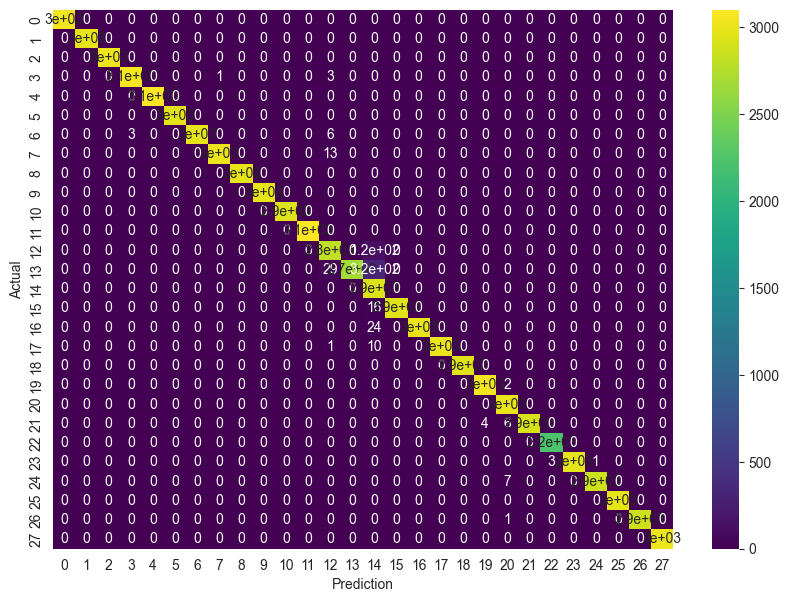

In [29]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    cmap="viridis",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [30]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3027
           1       1.00      1.00      1.00      2981
           2       1.00      1.00      1.00      3017
           3       1.00      1.00      1.00      3062
           4       1.00      1.00      1.00      3079
           5       1.00      1.00      1.00      2975
           6       1.00      1.00      1.00      2994
           7       1.00      1.00      1.00      3020
           8       1.00      1.00      1.00      2975
           9       1.00      1.00      1.00      2983
          10       1.00      1.00      1.00      2931
          11       1.00      1.00      1.00      3098
          12       0.98      0.96      0.97      2921
          13       1.00      0.88      0.94      3027
          14       0.86      1.00      0.92      2938
          15       1.00      0.99      1.00      2964
          16       1.00      0.99      1.00      3015
          17       1.00    

In [31]:
model_poly = svm.SVC(kernel='poly', degree=3)
model_poly.fit(x_train, y_train)

SVC(kernel='poly')

In [32]:
y_test_pred_poly = model_poly.predict(x_test)

In [33]:
accuracy = accuracy_score(y_test, y_test_pred_poly)
precision = precision_score(y_test, y_test_pred_poly, average="weighted")
recall = recall_score(y_test, y_test_pred_poly, average="weighted")
f1 = f1_score(y_test, y_test_pred_poly, average="weighted")
cm = confusion_matrix(y_test, y_test_pred_poly)
report = classification_report(y_test, y_test_pred_poly)

In [34]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Accuracy: 0.9997464839741655
Precision: 0.9997468807127602
Recall: 0.9997464839741655
F1: 0.9997465045571565


Text(95.72222222222221, 0.5, 'Actual')

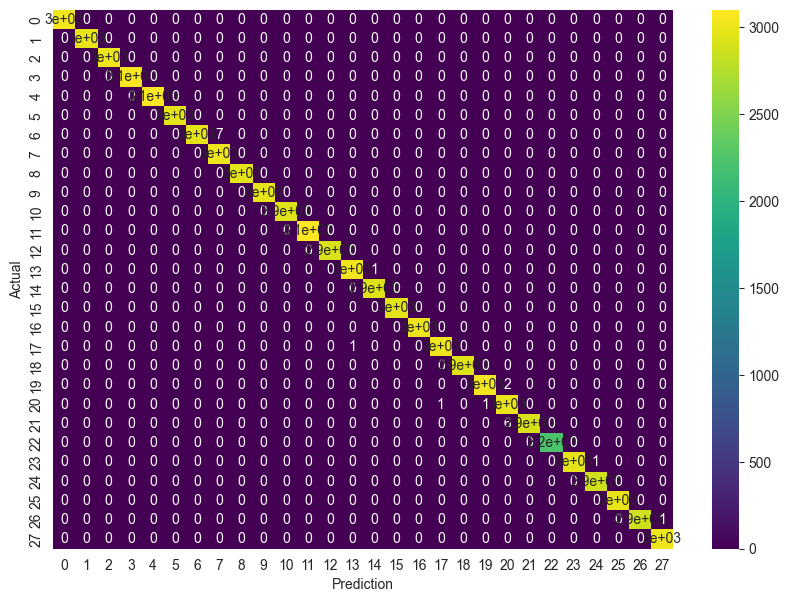

In [35]:
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    cmap="viridis",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [36]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3027
           1       1.00      1.00      1.00      2981
           2       1.00      1.00      1.00      3017
           3       1.00      1.00      1.00      3062
           4       1.00      1.00      1.00      3079
           5       1.00      1.00      1.00      2975
           6       1.00      1.00      1.00      2994
           7       1.00      1.00      1.00      3020
           8       1.00      1.00      1.00      2975
           9       1.00      1.00      1.00      2983
          10       1.00      1.00      1.00      2931
          11       1.00      1.00      1.00      3098
          12       1.00      1.00      1.00      2921
          13       1.00      1.00      1.00      3027
          14       1.00      1.00      1.00      2938
          15       1.00      1.00      1.00      2964
          16       1.00      1.00      1.00      3015
          17       1.00    

In [37]:
num_classes = len(data)

classes = []

for _, c in data:
    classes.append(c)

In [38]:
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'Nothing',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'Space',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [39]:
y_data = df['Label']
x_data = df.drop(columns=['Label', 'Image_No'])

In [40]:
num_classes = len(y_data.unique())

In [41]:
print(num_classes)

28


In [42]:
x_transformed = MinMaxScaler().fit_transform(x_data)
y_transformed = LabelEncoder().fit_transform(y_data)
data = {}

pca = PCA(n_components=4)
data["PCA"] = pca.fit_transform(x_transformed)

lda = LDA(n_components=3)
data["LDA"] = lda.fit_transform(x_transformed, y_transformed)

tsne = TSNE(n_components=3)
data["TSNE"] = tsne.fit_transform(x_transformed)

num_classes = len(classes)


Exception ignored in: <function _xla_gc_callback at 0x000001ED7C8513A0>
Traceback (most recent call last):
  File "C:\Users\rober\anaconda3\envs\new-misc-env\Lib\site-packages\jax\_src\lib\__init__.py", line 97, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
colors = plt.cm.tab20(np.linspace(0, 1, num_classes))


for key, value in data.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(num_classes):
        ax.scatter(data[key][y_transformed == i, 0], data[key][y_transformed == i, 1], label=classes[i], color=colors[i])
    fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.set_xlabel(f"{key} 1")
    ax.set_ylabel(f"{key} 2")
    plt.tight_layout(rect=(0., 0., 1., 1.))
    fig.suptitle(f'{key} Transformed Data', y=1.02)

In [ ]:
pca_x = data["PCA"]
pca_y = y_transformed

x_train, x_test, y_train, y_test = train_test_split(pca_x, pca_y)

model = svm.SVC(kernel='poly', degree=3)
model.fit(x_train, y_train)

pca_y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, pca_y_pred)
precision = precision_score(y_test, pca_y_pred, average="weighted")
recall = recall_score(y_test, pca_y_pred, average="weighted")
f1 = f1_score(y_test, pca_y_pred, average="weighted")
cm = confusion_matrix(y_test, pca_y_pred)
report = classification_report(y_test, pca_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    cmap="viridis",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")

print(report)

In [ ]:
pca_x = data["LDA"]
pca_y = y_transformed

x_train, x_test, y_train, y_test = train_test_split(pca_x, pca_y)

model = svm.SVC(kernel='poly', degree=3)
model.fit(x_train, y_train)

pca_y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, pca_y_pred)
precision = precision_score(y_test, pca_y_pred, average="weighted")
recall = recall_score(y_test, pca_y_pred, average="weighted")
f1 = f1_score(y_test, pca_y_pred, average="weighted")
cm = confusion_matrix(y_test, pca_y_pred)
report = classification_report(y_test, pca_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    cmap="viridis",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")

print(report)

In [ ]:
pca_x = data["TSNE"]
pca_y = y_transformed

x_train, x_test, y_train, y_test = train_test_split(pca_x, pca_y)

model = svm.SVC(kernel='poly', degree=3)
model.fit(x_train, y_train)

pca_y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, pca_y_pred)
precision = precision_score(y_test, pca_y_pred, average="weighted")
recall = recall_score(y_test, pca_y_pred, average="weighted")
f1 = f1_score(y_test, pca_y_pred, average="weighted")
cm = confusion_matrix(y_test, pca_y_pred)
report = classification_report(y_test, pca_y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    cmap="viridis",
)
plt.xlabel("Prediction")
plt.ylabel("Actual")

print(report)